In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
def plot_graphs(load_path, save_name):
    checkpoint = torch.load(load_path)
    test_acc = np.array(checkpoint['test_acc_list'])
    train_acc = np.array(checkpoint['train_acc_list'])
    test_loss = np.array(checkpoint['test_loss_list'])
    train_loss = np.array(checkpoint['train_loss_list'])
    x = np.array(list(range(0, len(test_acc))))


    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    if len(train_acc) == len(x):
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x, train_acc, color='r')
    else:
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x[1:], train_acc, color='r')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('loss')  # we already handled the x-label with ax1
    if len(train_loss) == len(x):
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, train_loss, color='y')
    else:
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x[1:], train_loss, color='y')
    ax2.tick_params(axis='y')

    #plt.xticks(list(range(0, len(x), 2)))
    ax1.legend(['test accuracy', 'train accuracy'])
    ax2.legend(['test loss', 'train loss'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    plt.savefig(save_name)
    #plt.show()


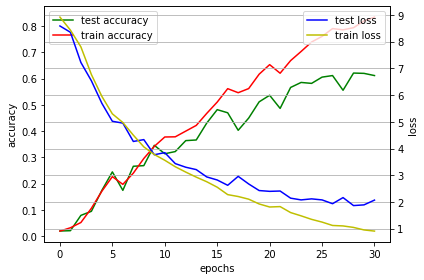

In [3]:
plot_graphs("models/birdnet_v1/birdnet_final.pt", "full")

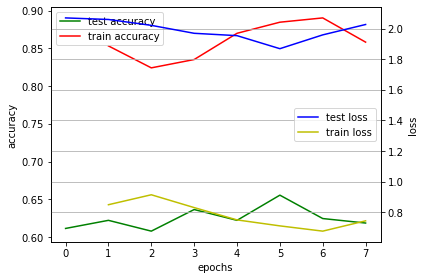

In [4]:
plot_graphs("models/pruned/block_05/birdnet_final.pt", "5")

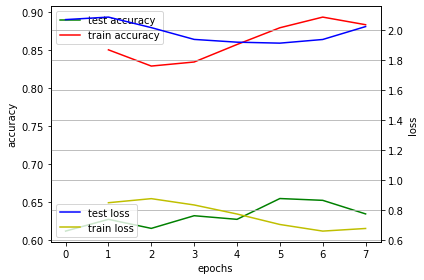

In [5]:
plot_graphs("models/pruned/block_10/birdnet_final.pt", "10")

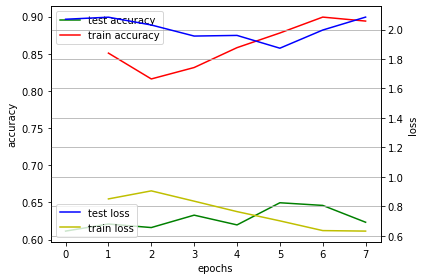

In [6]:
plot_graphs("models/pruned/block_15/birdnet_final.pt", "15")

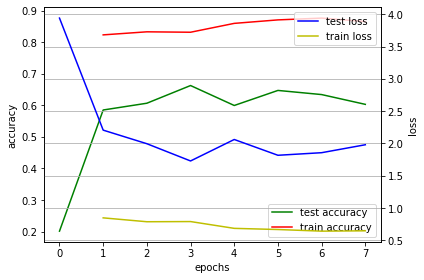

In [7]:
plot_graphs("models/pruned/block_20/birdnet_final.pt", "20")

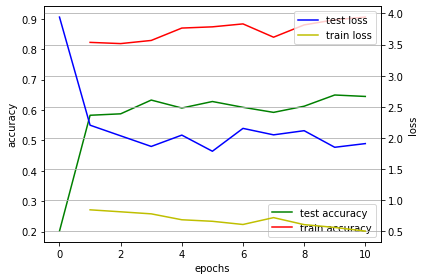

In [8]:
plot_graphs("models/pruned/block_25/birdnet_final.pt", "25")

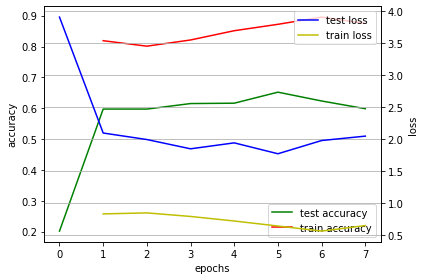

In [9]:
plot_graphs("models/pruned/block_30/birdnet_final.pt", "30")

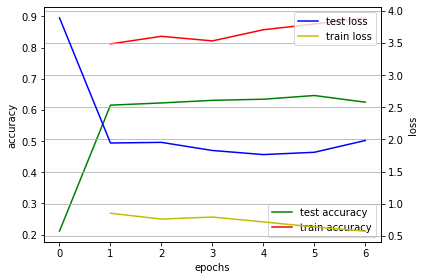

In [10]:
plot_graphs("models/pruned/block_40/birdnet_final.pt", "40")

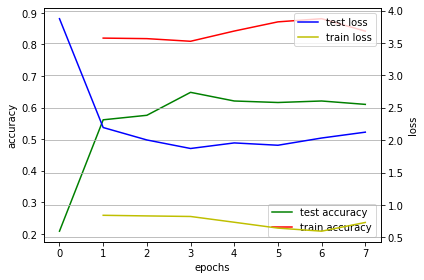

In [11]:
plot_graphs("models/pruned/block_50/birdnet_final.pt", "50")